In [1]:
#Ok here's what we need to do
#Model Build - start with ticketing vars (as it's members and ticket usage is biggest indicators)
#Incrementally add in vars
#Then final write-up:
#1. Listing out vars and process to get to inital model
#2. Adding in vars
#3. Tuning - ridge and folds

Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import imblearn as im
import numpy as np
import seaborn as sns
import snowflake.connector
import statsmodels.api as sm
from snowflake.connector.pandas_tools import write_pandas
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


Data Load

In [4]:
# snowlake connection
conn = snowflake.connector.Connect(user='ANALYST', password='Fedewap2023!', account='rl43903.east-us-2.azure')
sql = "select timeline.*, coalesce(surveys.form_responses, 0) as form_responses, coalesce(surveys.avg_form_sentiment, 0) as avg_form_sentiment, coalesce(surveys.avg_nps, 0) as avg_nps from (select * from CHICAGOFIRE_DATABASE.MODELING.STM_TIMELINE) as timeline left join (select EMAIL, year(event_date) as season_year, count(EVENT) as form_responses, avg(detail:sentiment[0]) as avg_form_sentiment, avg(detail:nps) as avg_nps from CHICAGOFIRE_DATABASE.MODELING.FAN_TIMELINE where lower(event) like '%form_response%' and EMAIL is not NULL and not lower(EMAIL) like 'none' group by EMAIL, year(event_date)) as surveys on timeline.EMAIL = surveys.EMAIL and timeline.SEASON_YEAR = surveys.SEASON_YEAR"
res = conn.cursor().execute(sql).fetchall()
#load in dataset
df = pd.read_sql(sql, conn)

C:\Users\dgilbert\AppData\Local\Temp\ipykernel_20368\2893316718.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


Pre-processing

In [817]:
df = df[df['SEASON_TICKET_MEMBER'] == 1]
df.fillna(0, inplace=True)
df['MLS_YEAR_TENURE'] = df['MLS_DAY_TENURE']/365.25

#Dropping vendors
df['ACCT_ID'] = df['ACCT_ID'].astype('int64')
ids_to_drop = [3790591, 295808, 348953, 31405, 114785, 4513005, 3496760]
df = df[~df['ACCT_ID'].isin(ids_to_drop)]

#Convert attendance to attendance rate
games_21 = 11 #could go to 16
games_22 = 18
games_23 = 22
df['ATTENDANCE_RATE'] = np.nan
df['SEASON_YEAR'] = df['SEASON_YEAR'].astype('int64')
df.loc[df.SEASON_YEAR == 2021, 'ATTENDANCE_RATE'] = df.loc[df.SEASON_YEAR == 2021, 'ATTEND_COUNT']/games_21
df.loc[df.SEASON_YEAR == 2022, 'ATTENDANCE_RATE'] = df.loc[df.SEASON_YEAR == 2022, 'ATTEND_COUNT']/games_22
df.loc[df.SEASON_YEAR == 2023, 'ATTENDANCE_RATE'] = df.loc[df.SEASON_YEAR == 2023, 'ATTEND_COUNT']/games_23

#Sum SF Fields
df['SF_SUM'] = df['SF_EMAILS'] + df['SF_LISTEMAILS'] + df['SF_CADENCES'] + df['SF_CALLS'] + df['SF_EVENTS'] + df['SF_TASKS']

#Combine forward and return counts
df['FORWARD_AND_RETURN'] = df['FORWARD_COUNT'] + df['RETURN_COUNT']

#Merch Binary
df['MERCH_BINARY'] = (df['MERCH_PURCHASES'] > 0).astype(int)

#Combine ticket and merch spend
df['SPEND'] = df['MERCH_SPEND'] + df['TICKET_SPEND']

In [818]:
df.isna().sum()

ACCT_ID                  0
EMAIL                    0
SEASON_YEAR              0
SEASON_TICKET_MEMBER     0
TICKET_COUNT             0
TICKET_SPEND             0
SUM_TICKET_COUNT         0
SUM_TICKET_SPEND         0
ATTEND_COUNT             0
RECEIVE_FORWARD_COUNT    0
FORWARD_COUNT            0
RETURN_COUNT             0
MERCH_PURCHASES          0
MERCH_SPEND              0
EMAIL_CLICKS             0
TICKET_EMAIL_CLICKS      0
CFYSC_REGISTRATIONS      0
SF_TASKS                 0
SF_LISTEMAILS            0
SF_EVENTS                0
SF_EMAILS                0
SF_CALLS                 0
SF_CADENCES              0
MLS_DAY_TENURE           0
ROOKIE                   0
RENEWED_NEXT_YEAR        0
FORM_RESPONSES           0
AVG_FORM_SENTIMENT       0
AVG_NPS                  0
MLS_YEAR_TENURE          0
ATTENDANCE_RATE          0
SF_SUM                   0
FORWARD_AND_RETURN       0
MERCH_BINARY             0
SPEND                    0
dtype: int64

EDA

In [701]:
df.shape
df.describe()
corr = df.corr()
corr.to_csv("C:/Users/dgilbert/Desktop/Code/Member Scoring Model/correlation_matrix_msm.csv")
corr

C:\Users\dgilbert\AppData\Local\Temp\ipykernel_18900\2771238768.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,ACCT_ID,SEASON_YEAR,SEASON_TICKET_MEMBER,TICKET_COUNT,TICKET_SPEND,SUM_TICKET_COUNT,SUM_TICKET_SPEND,ATTEND_COUNT,RECEIVE_FORWARD_COUNT,FORWARD_COUNT,...,ROOKIE,RENEWED_NEXT_YEAR,FORM_RESPONSES,AVG_FORM_SENTIMENT,AVG_NPS,MLS_YEAR_TENURE,ATTENDANCE_RATE,SF_SUM,FORWARD_AND_RETURN,MERCH_BINARY
ACCT_ID,1.000000,0.050358,NaN,-0.020136,0.002907,0.028365,0.013421,-0.045688,0.003952,0.007491,...,0.270638,-0.120205,-0.009337,0.019689,-0.021432,-0.269931,-0.071147,0.011220,0.019746,-0.007694
SEASON_YEAR,0.050358,1.000000,NaN,-0.270097,-0.075873,0.692434,0.398938,0.343945,0.100769,0.070970,...,-0.292970,0.096050,0.219517,0.059865,0.202298,0.291370,0.071359,0.656627,0.150700,-0.050126
SEASON_TICKET_MEMBER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TICKET_COUNT,-0.020136,-0.270097,NaN,1.000000,0.434870,-0.154638,-0.087172,0.143793,0.097564,0.485132,...,0.088673,0.329562,0.033100,-0.014926,0.020477,-0.095468,0.258053,-0.125061,0.406927,0.107535
TICKET_SPEND,0.002907,-0.075873,NaN,0.434870,1.000000,-0.070521,0.000302,-0.020839,0.036366,0.315595,...,0.039043,0.096283,-0.009954,-0.014097,-0.005686,-0.064728,-0.003728,-0.043024,0.251481,0.002939
SUM_TICKET_COUNT,0.028365,0.692434,NaN,-0.154638,-0.070521,1.000000,0.601324,0.277639,0.137835,0.043578,...,-0.218139,0.213358,0.162535,0.054305,0.059635,0.242100,0.089216,0.543282,0.065265,-0.022063
SUM_TICKET_SPEND,0.013421,0.398938,NaN,-0.087172,0.000302,0.601324,1.000000,0.133701,0.090578,0.077408,...,-0.134728,0.132881,0.084194,0.031444,0.027572,0.133420,0.029299,0.292849,0.055786,-0.017055
ATTEND_COUNT,-0.045688,0.343945,NaN,0.143793,-0.020839,0.277639,0.133701,1.000000,0.183009,0.002706,...,-0.170336,0.304245,0.345698,0.045719,0.316119,0.180420,0.933097,0.300771,0.035910,0.168371
RECEIVE_FORWARD_COUNT,0.003952,0.100769,NaN,0.097564,0.036366,0.137835,0.090578,0.183009,1.000000,0.216840,...,-0.051449,0.039424,0.058029,-0.003732,0.037804,0.056221,0.152036,0.123416,0.157727,0.020639
FORWARD_COUNT,0.007491,0.070970,NaN,0.485132,0.315595,0.043578,0.077408,0.002706,0.216840,1.000000,...,-0.037894,0.000267,0.009931,-0.003798,0.011049,0.027034,-0.018203,0.035722,0.806696,-0.013768


Modelling

Feature Selections

In [819]:
# All features
X = ['ATTENDANCE_RATE', 'TICKET_SPEND', 'FORWARD_AND_RETURN', 'TICKET_COUNT', 'RECEIVE_FORWARD_COUNT',
             'MERCH_PURCHASES', 'MERCH_SPEND', 'EMAIL_CLICKS', 'TICKET_EMAIL_CLICKS', 'CFYSC_REGISTRATIONS', 'SF_TASKS', 'SF_LISTEMAILS', 'SF_EVENTS', 'SF_EMAILS', 'SF_CALLS', 'SF_CADENCES', 
             'ROOKIE', 'FORM_RESPONSES', 'AVG_FORM_SENTIMENT', 'AVG_NPS', 'MLS_YEAR_TENURE']

# Merch as a binary
X_mb = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'TICKET_SPEND', 'RECEIVE_FORWARD_COUNT', 'FORWARD_COUNT',
             'MERCH_BINARY', 'MERCH_SPEND', 'EMAIL_CLICKS', 'TICKET_EMAIL_CLICKS', 'CFYSC_REGISTRATIONS', 'SF_TASKS', 'SF_LISTEMAILS', 'SF_EVENTS', 'SF_EMAILS', 'SF_CALLS', 'SF_CADENCES', 
             'ROOKIE', 'FORM_RESPONSES', 'AVG_FORM_SENTIMENT', 'AVG_NPS', 'MLS_YEAR_TENURE']

# Significant features only - coeff from standardizing > 0.1
X2 = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'TICKET_SPEND', 'FORWARD_COUNT', 'MERCH_PURCHASES', 'RETURN_COUNT', 
              'MLS_YEAR_TENURE', 'SF_LISTEMAILS', 'SF_CALLS', 'SF_EMAILS', 'ROOKIE', 'FORM_RESPONSES']

#SF_SUM
X3 = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'TICKET_SPEND', 'RECEIVE_FORWARD_COUNT', 'FORWARD_COUNT', 'RETURN_COUNT', 
             'MERCH_PURCHASES', 'MERCH_SPEND', 'EMAIL_CLICKS', 'TICKET_EMAIL_CLICKS', 'CFYSC_REGISTRATIONS', 'SF_SUM', 
             'ROOKIE', 'FORM_RESPONSES', 'AVG_FORM_SENTIMENT', 'AVG_NPS', 'MLS_YEAR_TENURE']

#Sig features only - SF_SUM
X4 = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'TICKET_SPEND', 'FORWARD_COUNT', 'EMAIL_CLICKS', 'RETURN_COUNT',
              'TICKET_EMAIL_CLICKS', 'SF_SUM', 'AVG_NPS', 'ROOKIE']

#Ticketing Related
X5 = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'TICKET_SPEND', 'FORWARD_AND_RETURN', 'MLS_YEAR_TENURE', 'ROOKIE']

X6 = ['ATTENDANCE_RATE', 'TICKET_SPEND', 'FORWARD_AND_RETURN', 'TICKET_COUNT', 'MERCH_BINARY', 'MERCH_SPEND', 'EMAIL_CLICKS', 'TICKET_EMAIL_CLICKS',  
      'SF_LISTEMAILS', 'SF_EMAILS', 'SF_CALLS', 'ROOKIE', 'FORM_RESPONSES', 'MLS_YEAR_TENURE']

X7 = ['ATTENDANCE_RATE', 'SPEND', 'FORWARD_AND_RETURN', 'TICKET_COUNT', 'MERCH_BINARY', 'EMAIL_CLICKS', 'TICKET_EMAIL_CLICKS',  
      'SF_LISTEMAILS', 'SF_EMAILS', 'SF_CALLS', 'ROOKIE', 'FORM_RESPONSES', 'MLS_YEAR_TENURE']

X8 = ['ATTENDANCE_RATE', 'SPEND', 'FORWARD_AND_RETURN', 'TICKET_COUNT', 'MERCH_BINARY', 'EMAIL_CLICKS', 'TICKET_EMAIL_CLICKS',  
      'SF_LISTEMAILS', 'SF_EMAILS', 'SF_CALLS', 'ROOKIE', 'FORM_RESPONSES', 'MLS_YEAR_TENURE']

y = df['RENEWED_NEXT_YEAR']
ytrain = df.loc[df['SEASON_YEAR'].isin([2021, 2022]), 'RENEWED_NEXT_YEAR']
ytest = df.loc[df['SEASON_YEAR'] == 2023, 'RENEWED_NEXT_YEAR']

In [687]:
df_train = df.loc[df['SEASON_YEAR'].isin([2021, 2022]), 'RENEWED_NEXT_YEAR']
ytest.value_counts()

1    1361
0     266
Name: RENEWED_NEXT_YEAR, dtype: int64

Make train and test

In [693]:
#Using 2023 as test set
Xtrain = df.loc[df['SEASON_YEAR'].isin([2021, 2022]), X5]
Xpredict = df.loc[df['SEASON_YEAR'] == 2023, X5]

In [820]:
#Using a true 80-20 split
Xtrain = df[X7]
X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2)

Models

Straight logit

In [655]:
model = sm.Logit(ytrain, Xtrain).fit(method='bfgs')
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.425854
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                           Logit Regression Results                           
Dep. Variable:      RENEWED_NEXT_YEAR   No. Observations:                 3873
Model:                          Logit   Df Residuals:                     3868
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.3529
Time:                        16:44:04   Log-Likelihood:                -1649.3
converged:                       True   LL-Null:                       -2548.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ATTENDANCE_RATE       

In [694]:
ytrain = ytrain.reset_index(drop=True)

In [695]:
ytrain

0       1
1       0
2       0
3       1
4       0
       ..
3868    0
3869    0
3870    1
3871    1
3872    0
Name: RENEWED_NEXT_YEAR, Length: 3873, dtype: int64

In [696]:
model = sm.Logit(ytrain, Xtrain_standard).fit(method='bfgs')
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.469975
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
                           Logit Regression Results                           
Dep. Variable:      RENEWED_NEXT_YEAR   No. Observations:                 3873
Model:                          Logit   Df Residuals:                     3868
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.2859
Time:                        17:02:03   Log-Likelihood:                -1820.2
converged:                       True   LL-Null:                       -2548.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ATTENDANCE_RATE       

L1 Penalization

In [571]:
model = sm.Logit(ytrain, Xtrain).fit_regularized(method='l1')
print(model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4258537938013437
            Iterations: 24
            Function evaluations: 28
            Gradient evaluations: 24
                           Logit Regression Results                           
Dep. Variable:      RENEWED_NEXT_YEAR   No. Observations:                 3873
Model:                          Logit   Df Residuals:                     3868
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.3529
Time:                        14:49:36   Log-Likelihood:                -1649.3
converged:                       True   LL-Null:                       -2548.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


L2 Penalization

In [821]:
model = LogisticRegression(penalty='l2', max_iter=2500).fit(X_train, y_train)

Folds

 21%|██        | 10/48 [01:04<05:15,  8.31s/it]c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 27%|██▋       | 13/48 [01:40<06:19, 10.84s/it]c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

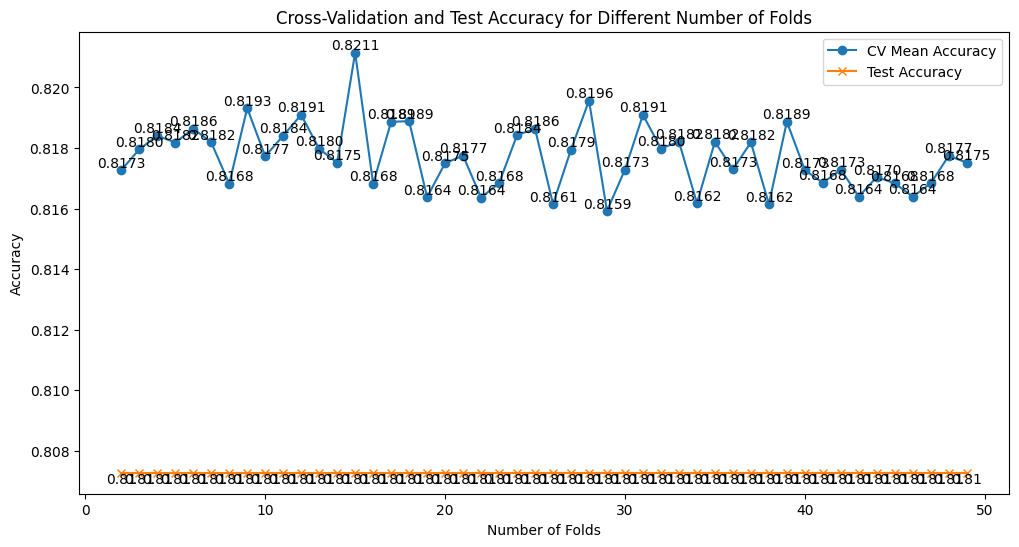

Best mean CV accuracy: 0.8211 achieved with 15 folds


In [836]:
def cross_validation_and_test_evaluation(X_train, y_train, X_test, y_test, max_folds=50):
    test_accuracies = []
    cv_mean_accuracies = []
    fold_range = tqdm(range(2, max_folds))

    best_cv_accuracy = 0
    best_fold_count = 0

    for n_folds in fold_range:
        # Cross-validation on the training set
        model = LogisticRegression(penalty='l2', max_iter=2500)
        kf = KFold(n_splits=n_folds)

        # Cross-validation scores
        cv_accuracies = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
        mean_accuracy = np.mean(cv_accuracies)
        cv_mean_accuracies.append(np.mean(cv_accuracies))

        if mean_accuracy > best_cv_accuracy:
            best_cv_accuracy = mean_accuracy
            best_fold_count = n_folds

        # Fit the model on the entire training set and evaluate on the test set
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_accuracies.append(test_accuracy)

    plt.figure(figsize=(12, 6))

    # Plotting CV accuracies
    plt.plot(range(2, max_folds), cv_mean_accuracies, marker='o', label='CV Mean Accuracy')
    
    # Plotting test accuracies
    plt.plot(range(2, max_folds), test_accuracies, marker='x', label='Test Accuracy')

    # Annotating each data point with its value
    for i, (cv_acc, test_acc) in enumerate(zip(cv_mean_accuracies, test_accuracies)):
        plt.text(i + 2, cv_acc, f"{cv_acc:.4f}", ha='center', va='bottom')
        plt.text(i + 2, test_acc, f"{test_acc:.2f}", ha='center', va='top')

    plt.xlabel('Number of Folds')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation and Test Accuracy for Different Number of Folds')
    plt.legend()
    plt.show()
    return best_fold_count, best_cv_accuracy


# Call the function with your feature set and target variable
best_fold, best_accuracy = cross_validation_and_test_evaluation(X_train, y_train, X_test, y_test)
print(f"Best mean CV accuracy: {best_accuracy:.4f} achieved with {best_fold} folds")

Accuracy, Recall, Precision, F1

In [ ]:
# Getting the predicted probabilities

predictions = model.predict_proba(Xpredict)
predictions

In [653]:
pos_preds = []
neg_preds = []
for prediction in predictions:
    trueprediction = prediction[1]
    if prediction[1] > .5:
        pos_preds.append(trueprediction)
    else:
        neg_preds.append(trueprediction)

print(f'positive preds avg: {sum(pos_preds)/len(pos_preds)} negative preds avg: {sum(neg_preds)/len(neg_preds)}')


Confusion Matrix

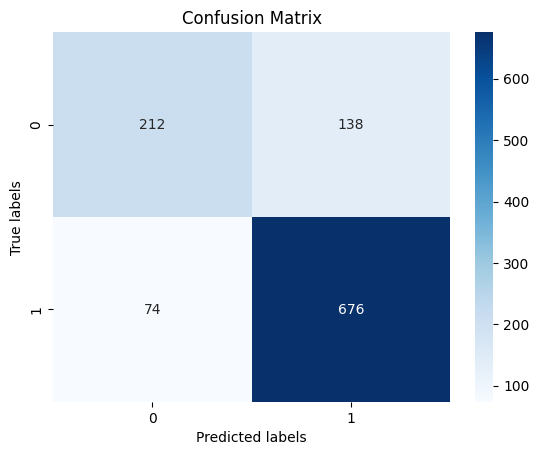

In [827]:
from sklearn.metrics import confusion_matrix

predictions_binary = model.predict(X_test)
cm = confusion_matrix(y_test, predictions_binary)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [828]:
predictions_binary = model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions_binary)
print(test_accuracy)

0.8072727272727273


Feature Importance

In [746]:
#Ticketing
Ticketing = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'TICKET_SPEND', 'FORWARD_AND_RETURN', 'MLS_YEAR_TENURE', 'ROOKIE']

In [747]:
#Salesforce Rep Interactions
Reps = ['SF_TASKS', 'SF_EMAILS', 'SF_LISTEMAILS', 'SF_CALLS', 'SF_CADENCES', 'SF_EVENTS', 'MLS_YEAR_TENURE', 'ROOKIE']

In [748]:
#Email interactions
Emails = ['EMAIL_CLICKS', 'TICKET_EMAIL_CLICKS', 'MLS_YEAR_TENURE', 'ROOKIE']

In [5]:
#Formstack sentiment
Sentiment = ['FORM_RESPONSES', 'AVG_FORM_SENTIMENT', 'AVG_NPS', 'MLS_YEAR_TENURE', 'ROOKIE']

In [786]:
Merch = ['MERCH_PURCHASES', 'MERCH_SPEND', 'MERCH_BINARY', 'MLS_YEAR_TENURE', 'ROOKIE']

In [822]:
Xtrain = df[X7]


#Standardizer
scaler = StandardScaler()
Xtrain_standard = scaler.fit_transform(Xtrain)
Xtrain_standard = pd.DataFrame(Xtrain_standard)
Xtrain_standard.columns = Xtrain.columns

X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xtrain_standard, y, test_size=0.2)

In [823]:
model = LogisticRegression(penalty='l2', max_iter=5000).fit(X_train, y_train)
model_s = LogisticRegression(penalty='l2', max_iter=5000).fit(X_train_s, y_train_s)

In [824]:
# Get the coefficients
coefficients = model.coef_[0]
coefficients_standard = model_s.coef_[0]

# Create a DataFrame for easy viewing
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_names_s = X_train_s.columns
importance_df = pd.DataFrame({'Feature': feature_names_s, 'Standardized Coefficients': coefficients_standard})

In [825]:
coef_df

,Feature,Coefficient
0,ATTENDANCE_RATE,1.348132e+00
1,SPEND,6.295129e-07
2,FORWARD_AND_RETURN,-3.821866e-02
3,TICKET_COUNT,1.534478e-01
4,MERCH_BINARY,5.168995e-01
5,EMAIL_CLICKS,2.503815e-02
6,TICKET_EMAIL_CLICKS,-2.561963e-02
7,SF_LISTEMAILS,5.632275e-02
8,SF_EMAILS,1.346699e-02
9,SF_CALLS,-2.306470e-02


In [826]:
importance_df

,Feature,Standardized Coefficients
0,ATTENDANCE_RATE,0.455930
1,SPEND,0.030972
2,FORWARD_AND_RETURN,-0.954996
3,TICKET_COUNT,1.623096
4,MERCH_BINARY,0.151137
5,EMAIL_CLICKS,0.434077
6,TICKET_EMAIL_CLICKS,-0.224353
7,SF_LISTEMAILS,0.931388
8,SF_EMAILS,0.080033
9,SF_CALLS,-0.274009


Everything

In [772]:
coef_df

,Feature,Coefficient
0,ATTENDANCE_RATE,1.699182
1,TICKET_SPEND,-0.000023
2,FORWARD_AND_RETURN,-0.037162
3,TICKET_COUNT,0.154361
4,RECEIVE_FORWARD_COUNT,-0.024729
5,MERCH_PURCHASES,0.217775
6,MERCH_SPEND,-0.000158
7,EMAIL_CLICKS,0.029033
8,TICKET_EMAIL_CLICKS,-0.026234
9,CFYSC_REGISTRATIONS,-0.135120


In [773]:
importance_df

,Feature,Standardized Coefficients
0,ATTENDANCE_RATE,0.411259
1,TICKET_SPEND,-0.048740
2,FORWARD_AND_RETURN,-0.947210
3,TICKET_COUNT,1.792423
4,RECEIVE_FORWARD_COUNT,-0.049853
5,MERCH_PURCHASES,0.145098
6,MERCH_SPEND,0.022829
7,EMAIL_CLICKS,0.540481
8,TICKET_EMAIL_CLICKS,-0.231932
9,CFYSC_REGISTRATIONS,-0.049966


Ticketing - with and without ticket spend

In [738]:
coef_df

,Feature,Coefficient
0,ATTENDANCE_RATE,2.427710
1,TICKET_COUNT,0.121082
2,FORWARD_AND_RETURN,-0.029729
3,MLS_YEAR_TENURE,0.170564
4,ROOKIE,-1.095208


In [745]:
coef_df

,Feature,Coefficient
0,ATTENDANCE_RATE,2.224039
1,TICKET_COUNT,0.126543
2,TICKET_SPEND,-0.000013
3,FORWARD_AND_RETURN,-0.027428
4,MLS_YEAR_TENURE,0.167030
5,ROOKIE,-1.140067


In [739]:
importance_df

,Feature,Standardized Coefficients
0,ATTENDANCE_RATE,0.584627
1,TICKET_COUNT,1.353544
2,FORWARD_AND_RETURN,-0.697292
3,MLS_YEAR_TENURE,0.281192
4,ROOKIE,-0.528354


In [744]:
importance_df

,Feature,Standardized Coefficients
0,ATTENDANCE_RATE,0.610950
1,TICKET_COUNT,1.428245
2,TICKET_SPEND,-0.017352
3,FORWARD_AND_RETURN,-0.837912
4,MLS_YEAR_TENURE,0.294298
5,ROOKIE,-0.523248


Reps

In [753]:
coef_df

,Feature,Coefficient
0,SF_TASKS,-0.001497
1,SF_EMAILS,0.016518
2,SF_LISTEMAILS,0.036206
3,SF_CALLS,-0.017198
4,SF_CADENCES,0.128298
5,SF_EVENTS,0.149287
6,MLS_YEAR_TENURE,0.086589
7,ROOKIE,-0.552020


In [754]:
importance_df

,Feature,Standardized Coefficients
0,SF_TASKS,-0.048416
1,SF_EMAILS,0.109663
2,SF_LISTEMAILS,0.606220
3,SF_CALLS,-0.212013
4,SF_CADENCES,0.001862
5,SF_EVENTS,0.064925
6,MLS_YEAR_TENURE,0.150740
7,ROOKIE,-0.307270


Email Interactions

In [758]:
coef_df

,Feature,Coefficient
0,EMAIL_CLICKS,0.076044
1,TICKET_EMAIL_CLICKS,-0.060366
2,MLS_YEAR_TENURE,0.073955
3,ROOKIE,-0.675634


In [759]:
importance_df

,Feature,Standardized Coefficients
0,EMAIL_CLICKS,1.439726
1,TICKET_EMAIL_CLICKS,-0.714926
2,MLS_YEAR_TENURE,0.174277
3,ROOKIE,-0.264292


Formstack Sentiment

In [763]:
coef_df

,Feature,Coefficient
0,FORM_RESPONSES,0.203315
1,AVG_FORM_SENTIMENT,0.237482
2,AVG_NPS,-0.025023
3,MLS_YEAR_TENURE,0.097353
4,ROOKIE,-0.647034


In [764]:
importance_df

,Feature,Standardized Coefficients
0,FORM_RESPONSES,0.599954
1,AVG_FORM_SENTIMENT,0.049751
2,AVG_NPS,-0.093115
3,MLS_YEAR_TENURE,0.181161
4,ROOKIE,-0.326952


Merch

In [790]:
coef_df

,Feature,Coefficient
0,MERCH_PURCHASES,0.139783
1,MERCH_SPEND,0.000729
2,MERCH_BINARY,0.501539
3,MLS_YEAR_TENURE,0.108200
4,ROOKIE,-0.761968


In [791]:
importance_df

,Feature,Standardized Coefficients
0,MERCH_PURCHASES,0.081204
1,MERCH_SPEND,0.178255
2,MERCH_BINARY,0.112432
3,MLS_YEAR_TENURE,0.182175
4,ROOKIE,-0.366051


In [ ]:
if 'results' not in globals():
    results = pd.DataFrame(columns=['Feature_Set', 'Accuracy', 'Precision', 'Recall', 'Notes'])

def append_to_results(df, feature_set, accuracy, precision, recall, notes):
    # Create a new row with the provided data
    new_data = {
        'Feature_Set': str(feature_set),  # Converting feature set to string for representation
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Notes': notes
    }
    # Append the new row to the DataFrame
    df = df.append(new_data, ignore_index=True)
    return df

results = append_to_results(results, X.columns.tolist(), accuracy, precision, recall, "Your notes here")